### Face detection

### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [ ]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

In [ ]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

In [4]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### MediaPipe Compatibility Fix (Python 3.12+ / January 2026)
Note: Since the Google Colab update in early 2026, MediaPipe has changed its package structure. If you encounter AttributeError: module 'mediapipe' has no attribute 'solutions' or ModuleNotFoundError, please run the two cells below.

In [ ]:
!pip uninstall -y mediapipe
!rm -rf /usr/local/lib/python3.12/dist-packages/mediapipe

# 2. Instalacja wersji zgodnej z 3.12 (bez cache)
!pip install --no-cache-dir mediapipe==0.10.14

# 3. WYMUSZENIE RESTARTU - to zabije sesję i odświeży ścieżki
import os
os.kill(os.getpid(), 9)

#### Face detection

In [5]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Dlib functions (function-based module)
from data_preparation.processing_pipeline_dlib import (
    init_dlib,
    process_frame as dlib_process_frame,
)

# MediaPipe functions (function-based module)
from data_preparation.processing_pipeline_mediapipe import (
    create_face_mesh,
    load_reference_keypoints,
    process_frame as mp_process_frame,
    visualize_raw_detection,
    visualize_frontalized_points,
)


In [6]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
DATA_DIR = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain/')
FRAME_SKIP = 3  # tune to scan fewer/more frames per video

# Dlib resource paths
PREDICTOR_PATH = os.path.join(COLAB_ROOT, 'data', 'shape_predictor_68_face_landmarks.dat')
MEAN_FACE_PATH = os.path.join(COLAB_ROOT, 'data', 'landmarks_mean_face.npy')
WEIGHTS_PATH = os.path.join(COLAB_ROOT, 'data', 'frontalization_weights.npy')


def list_sample_videos(base_dir, limit=50):
    samples = []
    for subj in sorted(os.listdir(base_dir)):
        subj_path = os.path.join(base_dir, subj)
        if not os.path.isdir(subj_path):
            continue
        for fn in sorted(os.listdir(subj_path)):
            if fn.lower().endswith('.mp4'):
                samples.append(os.path.join(subj_path, fn))
                if len(samples) >= limit:
                    return samples
    return samples


sample_videos = list_sample_videos(DATA_DIR, limit=50)
print("Found sample videos:", len(sample_videos))

VIDEO_SAMPLE = sample_videos[0] if sample_videos else None
print("Default sample:", VIDEO_SAMPLE)


Found sample videos: 50
Default sample: /content/drive/MyDrive/PainRecognitionProject/data/BioVid_HeatPain/071309_w_21/071309_w_21-BL1-081.mp4


In [7]:
# Initialize Dlib
dlib_ctx = init_dlib(PREDICTOR_PATH, MEAN_FACE_PATH, WEIGHTS_PATH)
print(
    "Dlib ready; frontalization weights available:",
    dlib_ctx.get('frontalization_weights') is not None
)

Dlib ready; frontalization weights available: True


In [8]:
# Load MediaPipe reference keypoints
mp_ref_kp, mp_ref_ok = load_reference_keypoints(
    os.path.join(COLAB_ROOT, 'data', 'key_points_xyz.npy')
)
print("MediaPipe reference loaded:", mp_ref_ok)

# Create MediaPipe FaceMesh
face_mesh = create_face_mesh()


MediaPipe reference loaded: True


In [9]:
def find_frame_with_dlib_detection(video_path, detector, predictor, max_frames=600):
    cap = cv2.VideoCapture(video_path)
    idx = 0

    while cap.isOpened() and idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        out = dlib_process_frame(
            frame,
            detector=detector,
            predictor=predictor,
            aligner=dlib_ctx.get('aligner'),
            frontalization_weights=dlib_ctx.get('frontalization_weights'),
            canonical_reference=dlib_ctx.get('canonical_reference'),
            frontalize=False,
            center_ref=False,
            visualize=False,
        )

        if out is not None:
            cap.release()
            return frame, out

        idx += 1

    cap.release()
    return None, None


def find_frame_with_mp_detection(video_path, face_mesh, max_frames=600):
    cap = cv2.VideoCapture(video_path)
    idx = 0

    while cap.isOpened() and idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)

        if results and results.multi_face_landmarks:
            cap.release()
            return frame, results

        idx += 1

    cap.release()
    return None, None


Dlib Face Detection


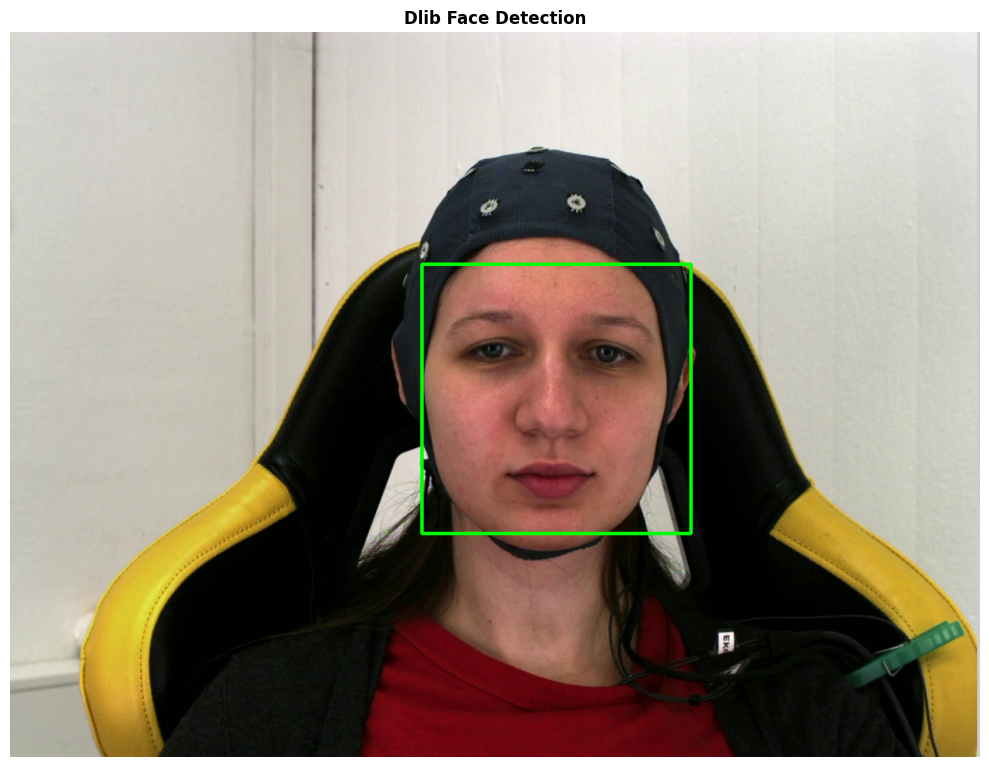

In [10]:
if VIDEO_SAMPLE is None:
    raise FileNotFoundError("Set VIDEO_SAMPLE to a valid .mp4 file first.")

frame, detection_out = find_frame_with_dlib_detection(
    VIDEO_SAMPLE,
    dlib_ctx['detector'],
    dlib_ctx['predictor'],
)

if frame is None:
    print("No Dlib detection found in first frames scanned.")
else:
    print("Dlib Face Detection")

    # Get face detection without landmarks
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = dlib_ctx['detector'](gray, 1)

    if rects:
        # Draw bounding box only
        img_with_box = frame.copy()
        for rect in rects:
            x, y, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
            cv2.rectangle(img_with_box, (x, y), (x2, y2), (0, 255, 0), 3)

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
        ax.set_title('Dlib Face Detection', fontsize=12, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


MediaPipe Face Detection - Bounding Box Only


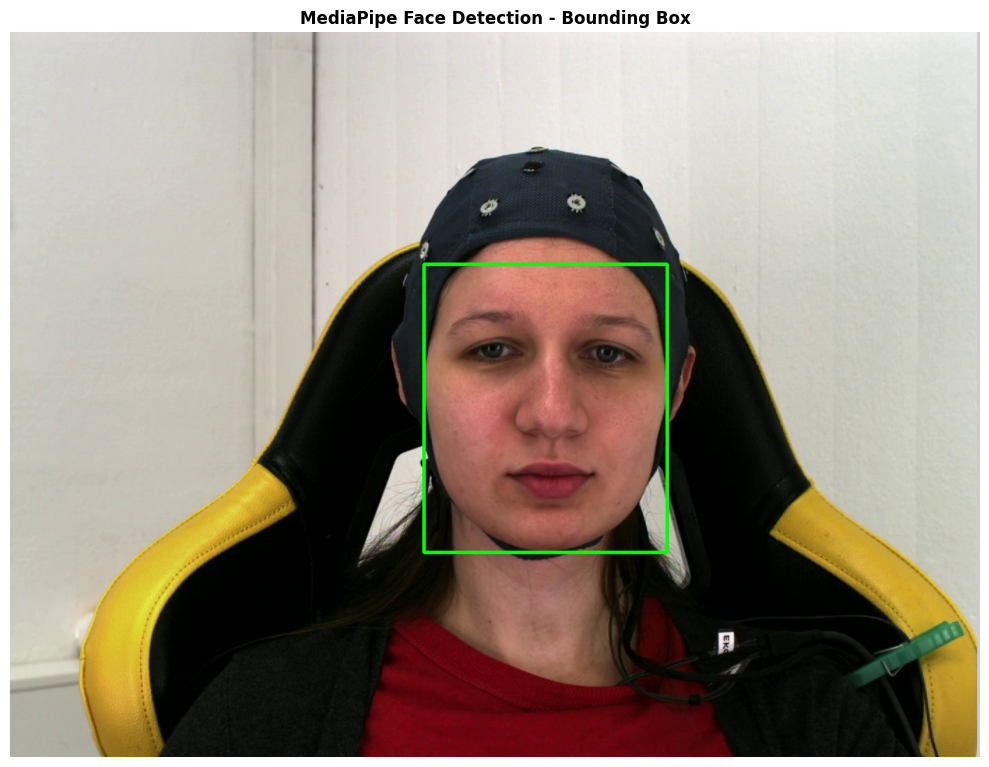

In [11]:
frame_mp, results = find_frame_with_mp_detection(VIDEO_SAMPLE, face_mesh)

if frame_mp is None:
    print("No MediaPipe detection found in first frames scanned.")
else:
    print("MediaPipe Face Detection - Bounding Box Only")

    # Draw bounding box only (from landmarks)
    img_with_box = frame_mp.copy()
    h, w = frame_mp.shape[:2]

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark

        # Get bounding box from landmarks
        xs = [lm.x * w for lm in landmarks]
        ys = [lm.y * h for lm in landmarks]

        x_min, x_max = int(min(xs)), int(max(xs))
        y_min, y_max = int(min(ys)), int(max(ys))

        # Draw bounding box
        cv2.rectangle(img_with_box, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
        ax.set_title('MediaPipe Face Detection - Bounding Box', fontsize=12, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

# Close when finished (or keep open for reuse)
face_mesh.close()
